In [21]:
# Math Section for Skuld model v2
import math
import numpy as np

a = 1 # the main part of what i will be changing for weights changes the size of the sigmoid without changing near zero
b = 0  # bias will add to updating with ^ later
m = 5 # the rate of change of the sigmoid 
c = 3 # a constant I used, same as but but shift the sigmod to a place where i 0 is close to 0 (actuyll 0.04 but whatever)
layer_bias = 0.5


def ians_sigmoid(x, a_a, b_b, m_m, c_c, layer=0):
    return 1/ ((1/a_a) + np.exp(((-x*m_m) + b_b + c_c + layer * layer_bias)))
#print(ians_sigmoid(0.8, a, b, m, c))

def calc_loss(output, desired):
    # can change but not a requirement yet
    return (0.5 * ((output - desired) ** 2))


def d_loss_d_weight_2(n1, n2, desired):
    # check the removal of the layer bias fo rthis one and go back to check the others as well
    return ((n2 - desired) * (n2) * (1-(n2)) * n1) # removedall layer_bias can check layer if correct call

def d_loss_d_weight_1(n1, n2, desired, w2, input):
    # check the removal of the layer bias fo rthis one and go back to check the others as well
    return ((n2 - desired) * (n2) * (1-(n2)) * n1 * w2 * (1- n1) * input)


def d_loss_d_bias_2(n2, desired):
    return (n2 - desired) * (n2 - layer_bias) * (1 - (n2 - layer_bias))

def d_loss_d_bias_1(n1, n2, delta2, desired, a2):
    #delta2 = (n2 - desired) * (n2 - layer_bias) * (1 - (n2 - layer_bias))
    return delta2 * a2 * (n1 - layer_bias) * (1 - (n1 - layer_bias))


def update_param(lr, grad, w):
    w -= lr * grad
    return w




def forward_pass(input, a1, a2, b1, b2):
    sig_r1 = ians_sigmoid(input, a1, b1, m, c)
    delay_1 = sig_r1 + input
    sig_r2 = ians_sigmoid(delay_1, a2, b2, m, c, layer=1)
    delay_2 = sig_r2 + delay_1

    return ([delay_1, delay_2], [sig_r1, sig_r2])


def run_basic(input, a1, a2, b1, b2, desired, lr):   # will need to check work on bias/b and make sure everything is correct in this

    result = forward_pass(input, a1, a2, b1, b2)
    output = result[0][1]
    n1 = result[0][0]
    n2 = result[0][1]
    print(n1, n2)
    #loss = calc_loss(output, desired)

    delta_a2 = - d_loss_d_weight_2(n1, n2, desired)

    delta_a1 = - d_loss_d_weight_1(n1, n2, desired, a2, input) # trying to just input a as a the weight directly

    new_a1 = update_param(lr, delta_a1, a1)
    new_a2 = update_param(lr, delta_a2, a2)


    delta_b2 = - d_loss_d_bias_2(n2, desired)
    delta_b1 = - d_loss_d_bias_1(n1, n2, delta_b2, desired, b2) # trying to just input a as a the weight directly


    new_b1 = update_param(lr, delta_b1, b1)
    new_b2 = update_param(lr, delta_b2, b2)

    return new_a1, new_a2, new_b1, new_b2, result


run_basic(0.8, 1, 1, 0, 0, 1.5, 0.1)


1.531058578630005 2.5156194845721944


(1.251878081591937,
 0.40713206666927926,
 0.0,
 -0.20790771067132474,
 ([1.531058578630005, 2.5156194845721944],
  [0.7310585786300049, 0.9845609059421894]))

In [31]:
class Neuron: 
    def __init__(self, layer, number):

        self.layer = layer
        self.number = number
    

        self.current_layer = 0
        self.next_layer = 0
        self.past_layer = 1
        self.input_syn = 0
        self.output_syn = 0
        
        
        self.spikes = 0
        #self.firetime = -1
        self.fired = False

        self.set_outputs(layer)
        if self.layer == 0:
            self.threshold = 1.0
        else: 
            self.threshold = 2/3 * (self.past_layer)   #+ (self.current_layer + 1) # previous layer # of n /2 seem like a good fit  # will change to fun that reflect # of inputs and layer -- number of inputs
        self.voltage = 0

        #self.collected = 0
        self.scheduled_spike = -10 # change to just runtime or somthng else
        self.spike_time = 1000
        

    def set_outputs(self, layer):
        '''Called with the creation of neuron create all the correct assocations for later here'''
        global input_layer, output_layer, syn_layer_1, syn_layer_2, hidden_layer, syn_outputs, past_layer
        if layer == 0:
            self.next_layer = hidden_layer
            #self.input_syn = 0 # remains nothing
            self.output_syn = syn_layer_1
        elif layer == 1:
            self.current_layer = hidden_layer
            self.next_layer = output_layer
            self.past_layer = input_layer
            self.input_syn = syn_layer_1
            self.output_syn = syn_layer_2
        elif layer == 2:
            self.current_layer = output_layer
            self.next_layer = output_layer # same amount of outputs
            self.past_layer = hidden_layer
            self.input_syn = syn_layer_2
            self.output_syn = syn_outputs
  

    def send_to_syn(self, time, delay):
        '''Sends out the times to the synapses of when they should arive at their next neuron'''
        global l1_a, l2_a, l1_b, l2_b, m, c
        self.fired = True
        #print(self.layer, self.number, time, delay)
        start = int(self.number * self.next_layer)
        for syn in self.output_syn[start:(start+(self.next_layer))]:
            #print('input: ', syn.input_neuron, "output ", syn.output_neuron, "on layer ", syn.layer)
            a = 1
            b = 0
            if self.layer == 1:
                a = l1_a[syn.input_neuron][syn.output_neuron]
                b = l1_b[syn.input_neuron][syn.output_neuron]
            if self.layer == 2:
                a = l2_a[syn.input_neuron][syn.output_neuron]
                b = l2_b[syn.input_neuron][syn.output_neuron]

            syn.spike_time = ians_sigmoid(time, a, b, m, c, layer=syn.layer) + delay
            print(ians_sigmoid(time, 1, 0, m, c, layer=syn.layer) + delay)
            print(ians_sigmoid(time, 2, 0, m, c, layer=syn.layer) + delay)
            #print(syn.spike_time, syn.layer)
            #print("syn a and b", a, b)
            #print("syna and b", syn.a, syn.b)
            #print("syn spike time & delay ", syn.spike_time, delay)
            #print("spike time send to syn ",syn.input_neuron,syn.output_neuron, "at time ", syn.spike_time)
            pass
        # for all sync going out from this one: 
            # set call ian_sig and set that synapaces time to reach at calculated time


    def check_arival(self):
        '''Check first if this neuron has alreay sent or not. If it hasn't then it goes to check the synapses to see if one has arrived'''
        if self.fired:
            return
        else:
            self.check_syn_arival()


    def check_syn_arival(self):
        '''used in check_arival it will see if neruon is ready to act now basied on arriving spikes'''
        global current_time
        #print(self.layer)
        if self.layer == 0: # only for input layer
            if self.scheduled_spike <= current_time: # if fired already checked
                self.voltage += 1
                #print("input voltage set at time ", current_time)
        else:

            start = self.number * (self.current_layer -1)
            for syn in self.input_syn[start: : self.current_layer]: # goes over all incoming synapaces
                if (syn.message_complete) == False: # if syn is has not yet given this neuron its message
                    #print(self.layer, syn.layer)
                    #print(syn.check_spike(), current_time, syn.layer)
                    if syn.check_spike() <= current_time: # will check if current step has been reached
                        #print(syn.check_spike(), current_time)
                        #print(self.layer, syn.layer)

                        #print(syn.check_spike(), current_time, self.layer)
                        # print("layer: ", self.layer)
                        # print("recived spike at: ",current_time)
                        syn.message_complete = True
                        #update neruons voltage
                        self.voltage += 1

        self.check_threshold_voltage()
        
                    
                    
    def check_threshold_voltage(self):
        global time_step
        if self.voltage >= self.threshold:
            #print(self.layer, self.voltage, self.threshold)
            #print("self.voltage: ", self.voltage)
            #print("threshold: ", self.threshold)
            self.spike_time = current_time
            #print(self.layer, self.spike_time)
            #print("spike time: ", current_time)
            self.send_to_syn(current_time, current_time)  # CHANGE IF LAYER NOT == 0?
        else:
            if current_time >= (self.layer):
                self.voltage += (time_step*self.past_layer) * 0.5 # will change such and whatnot just playing to start# 



class synapse:
    def __init__(self, input_neuron, output_neuron, layer, a, b):
        global run_time
        self.a = a
        self.b = b
        self.input_neuron = input_neuron
        self.output_neuron = output_neuron
        self.layer = layer
        self.spike_time = run_time
        self.message_complete = False

    def set_spiketime(self, time):
        self.spike_time = time


    def check_spike(self):
        return self.spike_time


In [28]:
import numpy as np
import math

input_layer = 1
hidden_layer = 1
output_layer = 1 
m = 5
c = 3

inputs = [.8] * input_layer # firing at 2 at lastest as of current if all ==2 or larger bc of the v+= x/2
run_time = 10

l1_a = [[2.0] * input_layer] * hidden_layer # need to change so not adress multiplyer
l1_b = [[0.0] * input_layer] * hidden_layer

l2_a = [[1.0] * hidden_layer] * output_layer
l2_b = [[0.0] * hidden_layer] * output_layer

# l3_a = [1.0] * output_layer
# l3_b = [0.0] * output_layer

neurons_input = []
neurons_hidden = []
neurons_output = []

syn_layer_1 = []
syn_layer_2 = []
syn_outputs = []

current_time = 0
time_step = 1

def create_new_neurons_network():
    count = 0
    for i in range(len(inputs)):
        n = Neuron(layer=0, number=i)  # will add later to add a and b and such
        #n.set_firetime(val)
        neurons_input.append(n)
        n.scheduled_spike = inputs[i] 
        #print('Neuron Input neuron ' + str(neurons_input[i].number), "scheduled time: ", n.scheduled_spike)

    count = 0
    for i in range (hidden_layer):
        n = Neuron(layer=1, number=i)
        neurons_hidden.append(n)
        #print("Neuron at layer 1: " + str(neurons_hidden[i].number))

    count = 0
    for i in range (output_layer):
        n = Neuron(layer=2, number=i)
        neurons_output.append(n)
        #print("Neuron at output layer: " + str(neurons_output[i].number))


def create_synapses():
    for input_n in neurons_input:
        for hidden_n in neurons_hidden:
            #print(input_n.number)
            #print(hidden_n.number)
            # create new object of synapics 
            #give the object to both neurons so one can output to and the other can edit it
            syn = synapse(input_neuron=input_n.number, output_neuron=hidden_n.number, layer=0, a=l1_a[input_n.number][input_n.number], b=l1_b[input_n.number][input_n.number]) 
            syn_layer_1.append(syn)

    for hidden_n in neurons_hidden:
        for output_n in neurons_output:
            #print("h", hidden_n.number)
            #print("0" , output_n.number)
            # create new object of synapics 
            #give the object to both neurons so one can output to and the other can edit it
            syn = synapse(input_neuron=hidden_n.number, output_neuron=output_n.number, layer=1, a=l2_a[hidden_n.number][hidden_n.number], b=l2_b[hidden_n.number][hidden_n.number]) 
            syn_layer_2.append(syn)

    
    for count in range(output_layer): # will check layer 
            syn = synapse(input_neuron=count, output_neuron=count, layer=2, a=a, b=b) 
            syn_outputs.append(syn)


    return 0


def genesis():
    create_new_neurons_network()
    create_synapses()
    return

def run_simulation(runtime, dx):
    global current_time, time_step
    time_step = 1.0/dx
  
    current_time = 0

    for i in range(runtime*dx):

        for n1 in neurons_input:
            n1.check_arival()
            pass 

        for n2 in neurons_hidden:
            n2.check_arival()
            pass 

        for n3 in neurons_output:
            n3.check_arival()
            pass

        #print("TIME", current_time)
        current_time += time_step
        

    return 
    



run_simulation(run_time, 1000)

print(l1_a)
print(l1_b)
print(l2_a)
print(l2_b)




[[2.0]]
[[0.0]]
[[1.0]]
[[0.0]]


In [ ]:
def run_new_111(desired, lr):   # will need to check work on bias/b and make sure everything is correct in this


    run_simulation(run_time, 1000)

    n1 = neurons_hidden[0].spike_time
    n2 = neurons_output[0].spike_time
    print("n1, n2 : ", n1, n2)
    #loss = calc_loss(output, desired)

    delta_a2 = - d_loss_d_weight_2(n1, n2, desired)

    syn_a1 = syn_layer_1[0].a
    syn_a2 = syn_layer_2[0].a

    delta_a1 = - d_loss_d_weight_1(n1, n2, desired, syn_a2, inputs[0]) # trying to just input a as a the weight directly

    new_a1 = update_param(lr, delta_a1, syn_a1)
    new_a2 = update_param(lr, delta_a2, syn_a2)

    syn_b1 = syn_layer_1[0].b
    syn_b2 = syn_layer_2[0].b

    delta_b2 = - d_loss_d_bias_2(n2, desired)
    delta_b1 = - d_loss_d_bias_1(n1, n2, delta_b2, desired, syn_b2) # trying to just input a as a the weight directly


    new_b1 = update_param(lr, delta_b1, syn_b1)
    new_b2 = update_param(lr, delta_b2, syn_b2)

    return new_a1, new_a2, new_b1, new_b2, n1, n2

#run_new_111(input, 1.5, 0.1)

genesis()

for i in range(10):
    genesis()    # needs to add reset for all that isn't the genesis call
    sa1, sa2, sb1, sb2, n1, n2 = run_new_111(1.5, 0.1)
    l1_a[0][0] = sa1
    l2_a[0][0] = sa2
    l1_b[0][0] = sb1
    l2_b[0][0] = sb2
    syn_layer_1[0].a = sa1
    syn_layer_2[0].a = sa2
    syn_layer_1[0].b = sb1
    syn_layer_2[0].b = sb2
    print("a1 and a2: ", sa1, sa2)
    #print("b1 and b2: ", b1, b2)
    print(np.round(n2, 3))

print(l1_a)
print(l1_b)
print(l2_a)
print(l2_b)


1.531058578630006
1.9522337695316603
1.531058578630006
1.9522337695316603
3.333717062059944
4.33286856836515
3.333717062059944
4.33286856836515
4.3349968716443605
5.33498748661736
4.3349968716443605
5.33498748661736
n1, n2 :  1.3819999999999586 1.3819999999999586
a1 and a2:  1.9079076892909652 1.2668843760944508
1.382
1.531058578630006
1.9522337695316603
3.333717062059944
4.33286856836515
4.3349968716443605
5.33498748661736
n1, n2 :  1.3819999999999586 1.3819999999999586
a1 and a2:  1.9045745628681074 1.2754935495168525
1.382
1.531058578630006
1.9522337695316603
3.333717062059944
4.33286856836515
4.3349968716443605
5.33498748661736
n1, n2 :  1.3819999999999586 1.3819999999999586
a1 and a2:  1.9012187860250893 1.284102722939254
1.382
1.531058578630006
1.9522337695316603
3.333717062059944
4.33286856836515
4.3349968716443605
5.33498748661736
n1, n2 :  1.3819999999999586 1.3819999999999586
a1 and a2:  1.8978403587619108 1.2927118963616557
1.382
1.531058578630006
1.9522337695316603
3.333717

In [12]:
create_synapses()      # create synapses objects once
for epoch in range(10):
   # clear out last run’s flags & times
    sa1, sa2, sb1, sb2, n1, n2 = run_new_111(1.5, 0.1)
    # write back into synapse objects:
    syn_layer_1[0].a = sa1
    syn_layer_2[0].a = sa2
    syn_layer_1[0].b = sb1
    syn_layer_2[0].b = sb2
    print(f"Epoch {epoch}: a1={sa1:.4f}, a2={sa2:.4f}, n2={n2:.3f}")


n1, n2 :  1.767999999999916 3.3349999999997437
Epoch 0: a1=-788.9205, a2=-52.0543, n2=3.335
n1, n2 :  1.767999999999916 3.3349999999997437
Epoch 1: a1=-869.7200, a2=-54.5807, n2=3.335
n1, n2 :  1.767999999999916 3.3349999999997437
Epoch 2: a1=-954.4410, a2=-57.1071, n2=3.335
n1, n2 :  1.767999999999916 3.3349999999997437
Epoch 3: a1=-1043.0835, a2=-59.6335, n2=3.335
n1, n2 :  1.767999999999916 3.3349999999997437
Epoch 4: a1=-1135.6476, a2=-62.1598, n2=3.335
n1, n2 :  1.767999999999916 3.3349999999997437
Epoch 5: a1=-1232.1331, a2=-64.6862, n2=3.335
n1, n2 :  1.767999999999916 3.3349999999997437
Epoch 6: a1=-1332.5401, a2=-67.2126, n2=3.335
n1, n2 :  1.767999999999916 3.3349999999997437
Epoch 7: a1=-1436.8687, a2=-69.7390, n2=3.335
n1, n2 :  1.767999999999916 3.3349999999997437
Epoch 8: a1=-1545.1187, a2=-72.2654, n2=3.335
n1, n2 :  1.767999999999916 3.3349999999997437
Epoch 9: a1=-1657.2903, a2=-74.7918, n2=3.335


In [25]:

input = 0.8

s1 = ians_sigmoid(input, 1.0, 0.0, m, c)  + input

s2 = ians_sigmoid(s1, 1.0, 0.0, m, c, layer=1) + s1


print(input, s1, s2 )


0.8 1.531058578630005 2.5156194845721944


1.2009999999999785 2.153999999999874 3.1539999999997637
final spike at None


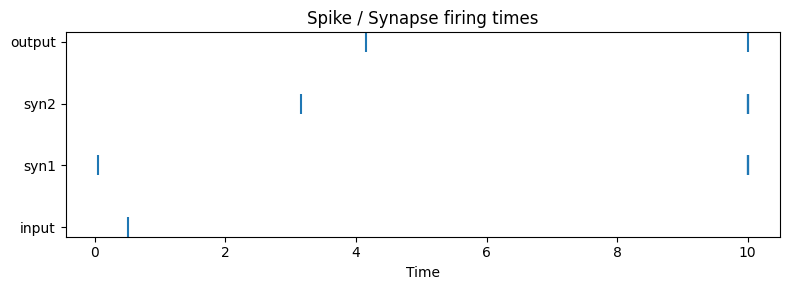

In [ ]:
# import matplotlib.pyplot as plt

# def plot_spike_raster(inputs,
#                       syn_layer_1,
#                       syn_layer_2,
#                       syn_outputs):
#     """
#     inputs: list of input‐neuron spike times
#     syn_layer_1: list of synapse objects for layer 1 (must have .spike_time)
#     syn_layer_2: list of synapse objects for layer 2
#     syn_outputs: list of synapse objects for output layer
#     """
#     # collect times & y‐positions
#     times = []
#     rows  = []
#     labels = []

#     # row 0 = input spikes
#     for t in inputs:
#         times.append(t)
#         rows.append(0)
#         labels.append("input")

#     # row 1 = layer‐1 synapses
#     for idx, s in enumerate(syn_layer_1):
#         times.append(s.spike_time)
#         rows.append(1)
#         labels.append(f"syn1_{idx}")

#     # row 2 = layer‐2 synapses
#     for idx, s in enumerate(syn_layer_2):
#         times.append(s.spike_time)
#         rows.append(2)
#         labels.append(f"syn2_{idx}")

#     # row 3 = output synapses
#     for idx, s in enumerate(syn_outputs):
#         times.append(s.spike_time)
#         rows.append(3)
#         labels.append(f"out_{idx}")

#     # now plot
#     plt.figure(figsize=(8, 3))
#     plt.scatter(times, rows, marker='|', s=200)
#     plt.yticks([0,1,2,3], ['input','syn1','syn2','output'])
#     plt.xlabel("Time")
#     plt.title("Spike / Synapse firing times")
#     plt.tight_layout()
#     plt.show()


# # Example usage:
# # (assuming you kept your syn_layer_1, syn_layer_2, syn_outputs in scope)
# final_time = run_simulation(inputs, run_time, 10000)
# print("final spike at", final_time)

# plot_spike_raster(
#     inputs,
#     syn_layer_1,
#     syn_layer_2,
#     syn_outputs
# )


In [10]:
# train

input = 0.8
lr = 0.1
a1 = 1
a2 = 1
b1 = 0
b2 = 0
desired = 1.5
# weird thing with moving the lr too much need to keep low nery steep start with changing lower m maybe?
for i in range(10):
    a1, a2, b1, b2, r = run_basic(input, a1, a2, b1, b2, desired, lr)
    print("a1 and a2: ", a1, a2)
    #print("b1 and b2: ", b1, b2)
    print(np.round(r[0][1], 3))





1.531058578630005 2.5156194845721944
a1 and a2:  1.251878081591937 0.40713206666927926
2.516
1.6571335960605762 2.063144700823308
a1 and a2:  1.2956886168605628 0.2024406690044006
2.063
1.676916173561962 1.8791175588090783
a1 and a2:  1.307202154880214 0.09741724872998553
1.879
1.6818700004637237 1.7792342217284562
a1 and a2:  1.3106622627454112 0.032305073085020175
1.779
1.6832721813101217 1.7155715191322405
a1 and a2:  1.3114488774430748 -0.012240813055488187
1.716
1.683527909572068 1.6712862785605762
a1 and a2:  1.3112323275285973 -0.04459284121985128
1.671
1.68336659445957 1.6387629245976822
a1 and a2:  1.310636230638757 -0.06904448046634425
1.639
1.6830553878788255 1.6139849606685595
a1 and a2:  1.3099189682577201 -0.0880554024301065
1.614
1.6827027859042039 1.5946051633952572
a1 and a2:  1.3091930599539456 -0.10314939375649158
1.595
1.6823548303448455 1.579147452828694
a1 and a2:  1.3085073612731895 -0.11532712476714699
1.579


0.0
result of ians_sig:  0.0066928509242848554
0.001
result of ians_sig:  0.006712824638845502
0.002
result of ians_sig:  0.006732857557639235
0.003
result of ians_sig:  0.006752949853738705
0.004
result of ians_sig:  0.006773101700708071
0.004999999999999999
result of ians_sig:  0.006793313272604322
0.006
result of ians_sig:  0.00681358474397857
0.007
result of ians_sig:  0.006833916289877375
0.008
result of ians_sig:  0.006854308085844063
0.009
result of ians_sig:  0.006874760307920044
0.009999999999999998
result of ians_sig:  0.0068952731326461444
0.011
result of ians_sig:  0.006915846737063922
0.012
result of ians_sig:  0.006936481298717
0.013
result of ians_sig:  0.006957176995652419
0.014
result of ians_sig:  0.006977934006421935
0.014999999999999998
result of ians_sig:  0.00699875251008339
0.016
result of ians_sig:  0.007019632686202042
0.017
result of ians_sig:  0.007040574714851911
0.018
result of ians_sig:  0.007061578776617127
0.018999999999999996
result of ians_sig:  0.0070

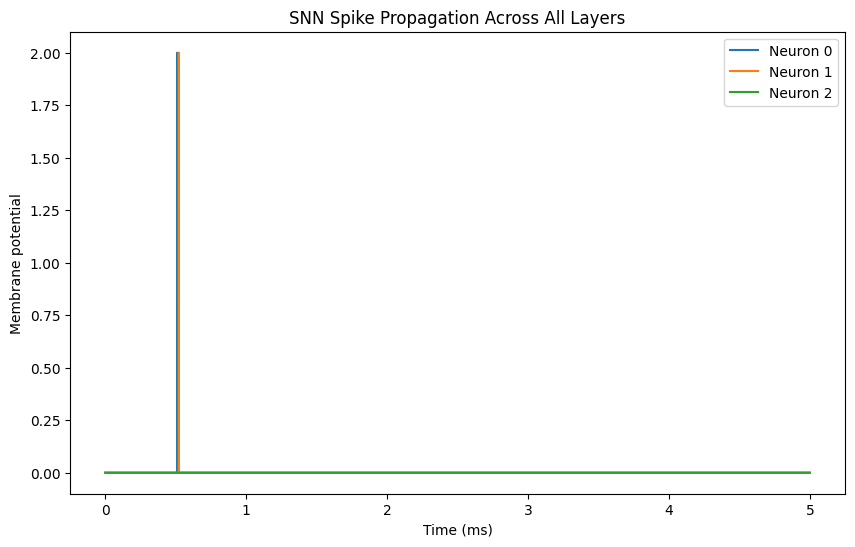

Neuron 0 spike times: ['0.511 ms']
Neuron 1 spike times: ['0.522 ms']


In [ ]:
# # Brian Simulation: 
# from brian2 import *
# import numpy as np
# import logging
# import warnings
# from brian2 import prefs, set_device
# # Tell Brian2 to use the Cython code generator:
# prefs.codegen.target = 'cython'

# # Optionally compile but keep Python interface:
# set_device('runtime')  # default; compiles operations to .so but stays in Python process

# # suppress overflow warnings
# warnings.filterwarnings('ignore', category=RuntimeWarning)
# numpy.seterr(over='ignore', under='ignore')
# logging.getLogger('brian2').setLevel(logging.ERROR)

# # ----------------------------------------------------------------------------
# # Spike timing and derivative
# layer_bias = 0.5
# start_scope()
# defaultclock.dt = 0.001*ms

# @implementation('numpy', discard_units=True)
# @check_units(time=1, a=1, b=1, m=1, c=1, layer=1, result=1)
# def ians_sigmoid(time, a, b, m, c, layer):
#     print(time)
#     global layer_bias
#     print("result of ians_sig: ", 1/ ((1/a) + np.exp(((-time*m) + b + c + layer * layer_bias))))
#     return 1/ ((1/a) + np.exp(((-time*m) + b + c + layer * layer_bias)))



# def mini1x1x1(inputs):
#     """
#     Mini 1x1x1 network with a single input, hidden, and output neuron.
#     This is a minimal example to demonstrate the basic structure of a spiking neural network.
#     """
#     # Define network sizes
#     n_input = 1
#     n_hidden = 1
#     n_output = 1
#     n_total = n_input + n_hidden + n_output

#     # Full neuron group
#     neurons = NeuronGroup(n_total, '''
#         v : 1
#         sum : 1
#         spikes_received : 1
#         scheduled_time : second
#         global_clock : 1
#         spiked : boolean
#     ''', threshold='v > 0.5', reset='''
#     v = 0
#     ''', method='exact')
#     neurons.v = 0
#     neurons.scheduled_time = 1e9 * second
#     neurons.global_clock = 0.0
#     neurons.sum = 0.0
#     neurons.spikes_received = 0.0

#     # Spike inputs (one per input neuron)     
#     stim = SpikeGeneratorGroup(n_input, indices=range(n_input), times=(inputs) * ms)

#     # Input → Hidden connections
#     syn_input = Synapses(stim, neurons[0:n_input], '''
#         layer : 1
#         a : 1
#         b : 1
#     ''', on_pre='''
#         spikes_received += 1
#         scheduled_time = (ians_sigmoid(t/ms, a, b, 3, 5, 0) + t/ms) * ms 
#     ''') 
#     syn_input.connect(j='i')  # connect stim[i] to neurons[i]
#     syn_input.layer = 0
#     syn_input.a = 5.0
#     syn_input.b = 0.0


#     # Hidden layer: input → hidden
#     syn_hidden = Synapses(neurons[0:n_input], neurons[n_input:n_input + n_hidden], '''
#         w : 1
#         layer : 1
#     ''', on_pre='''
#         spikes_received += 1
#         scheduled_time = (ians_sigmoid(t/ms, a, b, 3, 5, 0) + t/ms) * ms 
#     ''')
#     syn_hidden.connect()
#     #syn_hidden.w = w1 
#     syn_hidden.layer = 1

#     # Output layer: hidden → output
#     # syn_output = Synapses(neurons[n_input:n_input + n_hidden], neurons[n_input + n_hidden:n_total], '''
#     #     w : 1
#     #     layer : 1
#     # ''', on_pre='''
#     #     spikes_received += 1
#     #     v += 1
    
#     # ''')
#     # syn_output.connect()
#     # #syn_output.w = w2 
#     # syn_output.layer = 2

#     window = 0.02*ms

#     neurons.run_regularly('''
                          
#         v = int(abs(t - scheduled_time) < 0.005*ms) * 1.2
#         in_window = (scheduled_time >= (t - 0.02*ms)) * (scheduled_time <= (t + 0.02*ms))
   
#         fire_flag = int(in_window * (1 - spiked))
        
#         v      = fire_flag * 2
#         spiked = spiked or (fire_flag > 0)
  
#     ''', dt=0.001*ms)

#         #v = int(abs(t - scheduled_time) < 0.005*ms) * 1.2

#     # Monitors
#     mon = StateMonitor(neurons, 'v', record=True, dt=0.0001*ms)
#     mon_sum = StateMonitor(neurons, 'sum', record=True)
#     sp_mon = StateMonitor(neurons, 'spikes_received', record=True)
#     sch_time = StateMonitor(neurons, 'scheduled_time', record=True)


#     spikemon = SpikeMonitor(neurons)


#     run(5*ms)

#     # Plot voltages
#     figure(figsize=(10, 6))
#     for i in range(n_total):  # All neurons
#         plot(mon.t/ms, mon.v[i], label=f'Neuron {i}')
#     xlabel('Time (ms)')
#     ylabel('Membrane potential')
#     legend()
#     title('SNN Spike Propagation Across All Layers')
#     show()

#     # plot(mon_sum.t/ms, mon_sum.sum[3])  # or any neuron index
#     # print(mon_sum.sum[1])
#     # print(sp_mon.spikes_received[1])
#     # print(sch_time.scheduled_time[1])

#     for i in range(n_total):
#         times = spikemon.spike_trains()[i]
#         if len(times) > 0:
#             formatted_times = [f"{t/ms:.3f} ms" for t in times]
#             print(f"Neuron {i} spike times: {formatted_times}")

# input = [0.5]

# mini1x1x1(input)
